# Machine Learning Engineer Nanodegree
## Capstone Project
Darius Murawski
12.09.2018

# I. Definition
## Project Overview
### Problem Domain

Hard drives are used to save data from the operating system and different applications that are running on the server. The average price for a gigabyte is dropping and the demand for more space on the servers is growing. This results in a higher total number of hard drives running. As more drives are present in a data storage system, as more hard drives can fail, leading to data inconsistency and a major fail of the provided services. Since several years, hard drive vendors provide some values of this hard drives that reflect their current state. Based on this values, a broken drive can be identified. For more information on this so called S.M.A.R.T. values, see [wikipedia](https://en.wikipedia.org/wiki/S.M.A.R.T.). 

### Input Data overview

A crash of a hard drive in a private environment is happening very rarely because the amount of total dives is very low. I searched and found a huge dataset provied by [backblaze.com](https://www.backblaze.com/b2/hard-drive-test-data.html). They are running a huge data storage system with several thousend hard drive for their customers. For each quarter, the show their running and failed drives in a csv format for further research. They have a licence for this data, that I like to cite at this place: 

`You can download and use this data for free for your own purpose, all we ask is three things 1) you cite Backblaze as the source if you use the data, 2) you accept that you are solely responsible for how you use the data, and 3) you do not sell this data to anyone, it is free.`







## Problem Statement
Fails on a hard drive can be recovered using different techniques like raid settings or mirroring the data in different data centers. But the broken hard drive have to be replaced sooner or later with a new one, to make sure more fails on associated hard drives don’t break the data consistency. For each broken hard drive, somebody have to drive to the storage system, look it up in the storage system and replace it. This procedure have to be done each time one drive fails in the worst case and each time generating maintenance costs for the operating company. 

This costs can be reduced by replacing more drives than just the broken one by the maintenance people, as they only have to went to the storage system once and not several times. But what drives should they replace? In this Capstone project I want to generate a fail probability for each of the drives running in the storage system. The drives with a predicted fail should be replaced beforehand to reduce the maintenance costs in mid-range for the company operating the storage system.

The described problem can be seen as a binary classification problem, where the allowed labels are only 0, for “hard drive is running” and 1 for “hard drive failed”. When generating predictions, 0 represents “hard drive will run further” and 1 for “hard drive will (soon) fail and should be replaced. 

### Related papers and articles
Looking up in papers and articles, this kind of problem is referenced as predictive maintenance (PdM): Before waiting that something breaks, we replace the appropriate part in a regular maintenance to make sure that the entire system is able to continue running as expected.

|Authors|Topic / Title|Document|
|--|--|--|
|Julia Scavicchio|Definition “Predictive Maintenance” (PdM)”|[Link](https://www.hippocmms.com/blog/3-cmms-trends-for-2016-millennials-mobility-and-machine-learning)
|Jennifer Ho|Overview of industries, using Algorithms to reduce their machine downtime with further links|[Link](https://www.distrelec.de/current/en/artificial-intelligence/eliminating-machine-downtime-how-ai-is-transforming-maintenance/)
|Taylor Short|What type of sensors can be used for predictive maintenance|[Link](https://www.softwareadvice.com/resources/predictive-maintenance-reduce-downtime/)
|Gian Antonio Susto,<br> Andrea Schirru,<br> Simone Pampuri,<br> Seán McLoone,<br> Alessandro Beghi|Machine Learning for Predictive Maintenance: A Multiple Classifier Approach|[Link](https://ieeexplore.ieee.org/abstract/document/6879441)
|Dr. Miguel A. Sanz Bobi,<br> Maria Cruz García,<br> Javier del Pico-Aznar | SIMAP: Intelligent System for Predictive Maintenance: Application to the health condition monitoring of a windturbine gearbox|[Link](https://www.sciencedirect.com/science/article/pii/S0166361506000534)
|Hongfei Li,<br> Dhaivat Parikh,<br> Qing He,<br> Buyue Qian,<br> Zhiguo Li Dongping Fang,<br> Arun Hampapur| Improving rail network velocity: A machine learning approach to predictive maintenance | [Link](https://www.acsu.buffalo.edu/~qinghe/papers/journal/2014%20Railway%20Velocity.pdf)
|Eduardo Pinheiro,<br> Wolf-Dietrich Weber,<br> Luiz Andre Barroso - Google| Failure Trends in a Large Disk Drive Population| [Link](http://static.googleusercontent.com/media/research.google.com/en/us/archive/disk_failures.pdf) or [Link](https://ai.google/research/pubs/pub32774)
|Various|General Introduction into S.M.A.R.T.|[Link](https://en.wikipedia.org/wiki/S.M.A.R.T.)


## Solution Statement

I want to train a model that returns a "1", given by the provided features, that returns a prediction for a hard drive to fail. Drives with this value should be replaced by the maintenance team before.

## Metrics
The data is highly unbalanced. That results in using the F Beta Score to measure the performance of the model.

In [1]:
from sklearn.metrics import fbeta_score
  

def metric(y_pred, y_true):
    """
     Keyword arguments:
     y_pred - a list or np.array object containing the predicted values from a machine learning algorithm.
     y_true - a list or np.array object containing the correct labels that should match `y_pred`.
     
     As y_pred can have no predictions at all, we handle this special case and return a score of `0.0`.
    """
    # Preventing calculation warning from fbeta_score
    if np.array(y_pred).sum() == 0.0:
        return 0.0
    else:
        return fbeta_score(y_true, y_pred, average='macro', beta=1)

# II. Analysis

## Data Exploration
For each day and each drive an entry is generated in a quarter file that is than later on compressed and made available to the public. Failed drives are also included in this dataset and on the next day removed from the list. The dataset contains of the following columns (see: [backblaze.com](https://www.backblaze.com/b2/hard-drive-test-data.html)):

* Date – The date of the file in yyyy-mm-dd format.
* Serial Number – The manufacturer-assigned serial number of the drive.
* Model – The manufacturer-assigned model number of the drive.
* Capacity – The drive capacity in bytes.
* Failure – Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.
* Normalized and Raw S.M.A.R.T. values from 1 upto 255. The data have a different set of S.M.A.R.T. values.

The normalized values are sometimes not provided, for examle to return the amount of hours a drive was already running a normalization makes no sence. I decided to only use the raw values. The Ranges of the values are vendor specific. Thats why I decided not to build a model for everything, but instead generate a model specific one.

The entire dataset (I call it `raw`) is split into several pieces. Each piece referencing the year and the quarter that this data was extracted from. The following table shows some more detailed information about the dataset:

|file|year|quarter(s)|compressed MB|uncompressed MB|files|
|--  |  --|       --|           --|             --|   --|
|[data_2013.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_2013.zip)|2013|Q1,Q2,Q3,Q4|77|738|266|
|[data_2014.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_2014.zip)|2014|Q1,Q2,Q3,Q4|560|2880|365|
|[data_2015.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_2015.zip)|2015|Q1,Q2,Q3,Q4|803|4294|366|
|[data_Q1_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2016.zip)|2016|Q1|257|1356|92|
|[data_Q2_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2016.zip)|2016|Q2|278|1478|92|
|[data_Q3_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2016.zip)|2016|Q3|307|1604|92|
|[data_Q4_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2016.zip)|2016|Q4|321|1651|92|
|[data_Q1_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2017.zip)|2017|Q1|323|1659|90|
|[data_Q2_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2017.zip)|2017|Q2|368|1895|91|
|[data_Q3_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2017.zip)|2017|Q3|406|2027|92|
|[data_Q4_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2017.zip)|2017|Q4|434|2112|93|
|[data_Q1_2018.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2018.zip)|2018|Q1|484|2381|90|
|[data_Q1_2018.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2018.zip)|2018|Q2|502|2472|91|
|Total|2013 - 2018|14|5128|26536|1912|

For the first years, the data was collected on a year basis, but then starting from 2016, the data was splitted by quarter.

The Input Features are the hard drive model, and the returned S.M.A.R.T. values of the drive at the timestamp represented by "date". The data is highly unbalanced, as only about 1.8% drives in the reporting period between April 2003 and June 2018 failed (see: [backblaze.com](https://www.backblaze.com/blog/hard-drive-stats-for-q2-2018/)) .

As of time writing, Q2 for 2018 was the latest dataset. Note that the amount of information changed over time. From 2013 to 2014, 80 columns of data were collected for each drive. From 2015 to 2017 90 columns of data were collected. For Q2 2018, 104 columns with data was collected. Each reflecting a subset of the possible 256 S.M.A.R.T. "columns" with the raw and the normalized value. 

I choosed as an example the hard drive model "ST6000DX000" by Seagate for the visualization part. Examples are provided in "Exploratory Visualisation":

## Exploratory Visualization

The mapping and the preferred value-range of each S.M.A.R.T. value was extracted from [wikipedia.org](https://en.wikipedia.org/wiki/S.M.A.R.T.) - I extracted the map to the [helper.py](helper.py) to have a better overview inside the nodebook

I could extract three groups of features based on the following plots:
* Feature that seem to not be correlated to a fail of the given hard drive model
* Feature that are supposed to have a correlation, proposed by wikipedia
* Feature that seems to have a correlation, based on the plot. 

In [2]:
from helper import Helper
helper = Helper()
smart_to_name = helper.smart_to_name()

# We also need to define the basic column names, that are also present beside the S.M.A.R.T. values. 
# They are also extracted to the helper.py
column_list = helper.column_list()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import glob
import sys
import requests
import shutil
import zipfile
# see: https://docs.python.org/3/library/concurrent.futures.html
from concurrent.futures import Executor, ThreadPoolExecutor
import math
from math import floor
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from tqdm import tqdm
from joblib import Parallel, delayed
from time import time, sleep

from traceback import print_stack


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
# For clean resetting: https://stackoverflow.com/questions/45063602/attempting-to-reset-tensorflow-graph-when-using-keras-failing
from keras import backend as K

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [5]:
import xgboost as xgb

In [6]:
import lightgbm as lgb

This makes sure that my C: drives is not full of the downloaded data...

In [7]:
if os.path.exists(os.path.join('D:','capstone')):
    os.chdir(os.path.join('D:','capstone'))

In [8]:
if not os.path.exists(os.path.join('drives', 'ST6000DX000.csv')):
    raise Exception('Please run first the data preprocessing steps, before rerunning this cells as they depend on the preprocessing results!')

In [9]:
st_df = pd.read_csv(os.path.join('drives', 'ST6000DX000.csv'), names=column_list, header=None)

In [13]:
st_df.dropna(inplace=True, how='all', axis='columns')

In [14]:
st_df.rename(columns=smart_to_name, inplace=True)

Now lets take a look at the mapped data. Missing columns, that were generated while preprocessing, are now removed:

In [15]:
st_df.head()

,date,serial_number,model,capacity_bytes,failure,Read Error Rate,Spin-Up Time,Start/Stop Count,Reallocated Sectors Count,Seek Error Rate,...,Power-off Retract Count,Load Cycle Count,Temperature,Hardware ECC Recovered,Current Pending Sector Count,(Offline) Uncorrectable Sector Count,UltraDMA CRC Error Count,Head Flying Hours,Total LBAs Written,Total LBAs Read
0,2017-11-10,Z4D05G2K,ST6000DX000,6001175126016,0,15044280,0,11,0,1145162644,...,0,219262,25,15044280,0,0,2,146690313049158,38236743440,81807331858
1,2017-11-10,Z4D0ARTZ,ST6000DX000,6001175126016,0,12179803,0,5,0,1300171494,...,0,78657,24,12179803,0,0,0,215061897435155,46615460952,47540610070
2,2017-11-10,Z4D07B6E,ST6000DX000,6001175126016,0,135238309,0,15,0,1405133808,...,0,1447,28,135238309,0,0,0,207056078396721,29226952206,134425865010
3,2017-11-10,Z4D069T5,ST6000DX000,6001175126016,0,198113002,0,12,0,1313851777,...,0,33635,32,198113002,0,0,0,79276506372450,27643151347,175181733315
4,2017-11-10,Z4D03TNS,ST6000DX000,6001175126016,0,180317125,0,15,0,5644114135,...,0,68349,21,180317125,0,0,0,142073223206904,38344122896,94875351761


Lets check if any unmapped columns exist, that we have to take a look at:

In [16]:
st_df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'Read Error Rate', 'Spin-Up Time', 'Start/Stop Count',
       'Reallocated Sectors Count', 'Seek Error Rate', 'Power-On Hours',
       'Spin Retry Count', 'Power Cycle Count', 'SATA Downshift Error Count',
       'End-to-End error', 'Reported Uncorrectable Errors', 'Command Timeout',
       'High Fly Writes', 'Temperature Difference', 'G-sense Error Rate',
       'Power-off Retract Count', 'Load Cycle Count', 'Temperature',
       'Hardware ECC Recovered', 'Current Pending Sector Count',
       '(Offline) Uncorrectable Sector Count', 'UltraDMA CRC Error Count',
       'Head Flying Hours', 'Total LBAs Written', 'Total LBAs Read'],
      dtype='object')

no, everything is mapped given a name. Now lets define the plotting method:

In [8]:
def plot_feature(feature, df):
    plt.boxplot(
            [np.array(df[df['failure'] == 0][feature]), np.array(df[df['failure'] == 1][feature])],            
            vert=False,
            labels=['running: {}'.format(feature),'failed: {}'.format(feature)],
            autorange=True, widths=0.9)
    plt.show()  

### Not Correlated Features

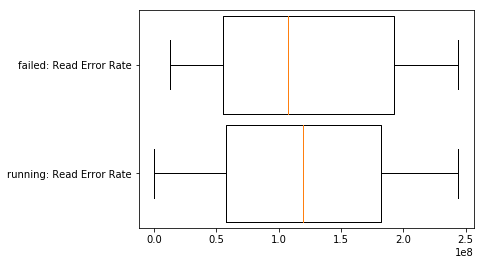

In [18]:
plot_feature('Read Error Rate', st_df)

This plot is an example to have no visual correlation between the failing of a drive and this S.M.A.R.T. value. It is not useful in our machine learning context. For most of the features, this is the case.

* Preferred: Low Values
* Not normalized between different hard drive vendor
* Correlation to Fail by Wikipedia: No

### Expected Correlation

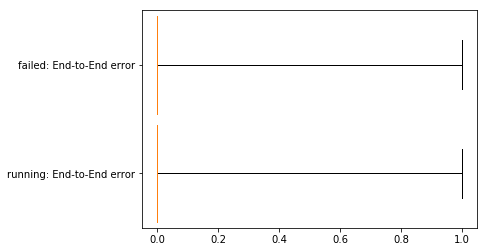

In [20]:
plot_feature('End-to-End error', st_df)

For the feature `End-to-End error`, we have the same boxplot for failed and for running devices. This value should be the count of parity errors. Its also interisting that this value is normalized from 0 upto 1. The representation as "error count" is not obvious at this point from a user perspective. From this representation I can't see an possible correlation with a failing drive. 

* Preferred: Low
* Correlation to Fail by Wikipedia: Yes

### Correlations found

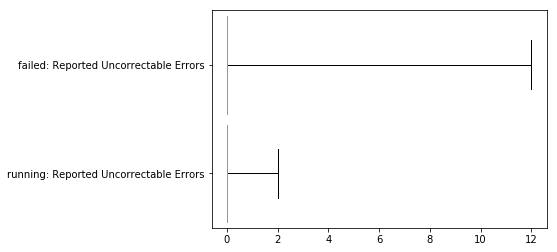

In [21]:
plot_feature('Reported Uncorrectable Errors', st_df)

One of the interisting features was `Reported Uncorrectable Errors` - this indeed looks very promising to be correlated to a hard drive fail, as the range of fail hard drives jumps upto 12 instead of being lower than 2.

* Referred: Low
* Correlation to Fail by Wikipedia: Yes
* **Correlation to Fail by given plot: Yes**

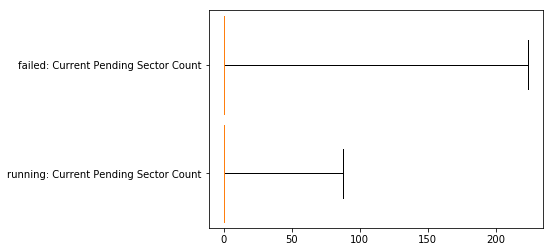

In [34]:
plot_feature('Current Pending Sector Count', st_df)

The feature `Current Pending Sector Count` seems to be a possible feature for predictions. Values above approx. 80 are only present for failing drives. This feature indicates the amount of "unstable" sectors on the hard drive.

* Preferred: Low
* Correlation to Fail by Wikipedia: Yes
* **Correlation to Fail by given plot: Yes**

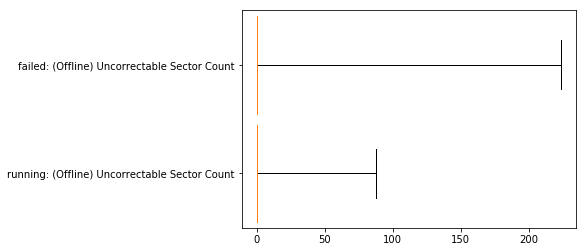

In [35]:
plot_feature('(Offline) Uncorrectable Sector Count', st_df)

This feature indicates the total count of uncorrectable errors while reading or writing. From the plot I assume a correlation between the fail of a hard drive and a value above approx. 80.

* Preferred: Low
* Correlation to Fail by Wikipedia: Yes
* **Correlation to Fail by given plot: Yes**

## Algorithms and Techniques

So fare we have worked with more balanced data and tried several algorithms against this datasets. But for heavy unbalanced data, I have no clue what algorithm to choose, so lets just try a lot of them and compare the results against each other based on their fbeta score! I searched all classfiers that I could found in scikit-learn and use them:


* SVC
* DecisionTreeClassifier
* LinearSVC
* SGDClassifier with max_iter=1000, tol=1e-3), # defaults in sklearn 0.21
* NearestCentroid
* GaussianNB,
* AdaBoostClassifier with n_estimators=100
* RandomForestClassifier with n_estimators=100, n_jobs=-1
* MLPClassifier

Most of this algorithms where run with their default settings. A different set of parameters could improve their results, but I wanted to have some all more or less good comparable based on their default settings.

I also tried a `Keras` neuronal network, `LightGBM` and `XGBoost` to even extend the amount of algorithms that are compared. For the last 3 algorithms I used a train, test and validation set. The validation set was used by the algorithm to improve. All tests sets where run after the model was generated to calculate the fbeta score.



## Benchmark
Googles(Eduardo Pinheiro et al.) results are as follows (link provided above, summary see wikipedia link):

* 60 days after finding uncorrectable errors (S.M.A.R.T. Value 198), the drive had 39 times higher change to fail
First errors in S.M.A.R.T. 196 (Relocation) and 5 (offline Relocation) are strongly correlated to higher probabilities of failure
* 56% of the drives failed without recording any count in the four string S.M.A.R.T. Warnings (Scan Errors, Relocation Count, offline Relocation and probiatinal Count)
* 36% Failed without any S.M.A.R.T. error at all

This lets me create the benchmark model as following:
The total amount of fails is 1.84% for all drives. 
This 1.84% can now be splitted into three groups, provided using the google paper:

Fails without errors: $1.84 \cdot 0.36 = 0.6624 %%$

Fails with any smart warning: $1.84 \cdot 0.56 = 1.0304 %$

Fails that could be predicted: $1.84 \cdot (1 - 0.36 - 0.56) = 0.8 %$ 

The Benchmark model, using random choice, predict with a change of 0.8% that a drive will fail. Each model have different chance to fail, this means that the 0.8 % is the average probability over every model in the dataset:

In [50]:
class FakeAlgorithm:
    def fit(self, X, y):
        # Nothing to calculate
        return self
    
    def predict(self, X):
        """
        X - feature matrix to generate predictions for.
        returns a list with 0 and 1 for each row in the feature matrix.
        """
        y_pred = []
        for i in range(len(X)):
            y_pred.append(int(random.random() <= 0.08))
        return y_pred


# Methodology
## Data Preprocessing


Lets define the base path for all zip files:

In [9]:
base_path = 'https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data'

To be able to run the stuff on my own environment, I change the working directory:

In [10]:
if os.path.exists(os.path.join('D:','capstone')):
    os.chdir(os.path.join('D:','capstone'))

Now we prepare the current directories that we will use. 
* raw - contains the raw zip files, downloaded from backblaze
* drives - contains a csv file for each hard drive model
* train - contains the training set for each hard drive model as csv
* test - contains the test set for each hard drive model as csv
* validate - contains the validation set for each hard drive model as csv
* tmp - temp directory for splitting and normalization
* drives_minified - removed every non relevant data and feature from a given hard drive
* sklearn_models - containing models and results of sklearn algorithms
* keras_models - containing models and results for keras
* xgboost_models - containing models and results for xgboost
* lightgbm_models - containing models and results for lightgbm

When using the preprocessed data referenced in the README.md, some of this directories will already exist.

In [11]:
os.makedirs('raw', exist_ok=True)      
os.makedirs('drives', exist_ok=True)   
os.makedirs('train', exist_ok=True)    
os.makedirs('test', exist_ok=True)   
os.makedirs('validate', exist_ok=True)
os.makedirs('tmp', exist_ok=True)
os.makedirs('drives_minified', exist_ok=True)
os.makedirs('sklearn_models', exist_ok=True)
os.makedirs('keras_models', exist_ok=True)
os.makedirs('xgboost_models', exist_ok=True)
os.makedirs('lightgbm_models', exist_ok=True)

Now we have a list of dict's:
* raw - the filename of the raw data
* url - the url that the data have to be fetched from
* zip - argument for the extraction, as the raw files for 2013, 2014 and 2015 contain a directory inside. All others are just the files directly, so we have to provide a directory to extract them. 

In [20]:
records = [
    {'raw': os.path.join('raw', 'data_Q2_2018.zip'), 'url': '{}/data_Q2_2018.zip'.format(base_path), 'zip': 'data_Q2_2018'},
    {'raw': os.path.join('raw', 'data_Q1_2018.zip'), 'url': '{}/data_Q1_2018.zip'.format(base_path), 'zip': 'data_Q1_2018'},
    {'raw': os.path.join('raw', 'data_Q4_2017.zip'), 'url': '{}/data_Q4_2017.zip'.format(base_path), 'zip': 'data_Q4_2017'},
    {'raw': os.path.join('raw', 'data_Q3_2017.zip'), 'url': '{}/data_Q3_2017.zip'.format(base_path), 'zip': 'data_Q3_2017'},
    {'raw': os.path.join('raw', 'data_Q2_2017.zip'), 'url': '{}/data_Q2_2017.zip'.format(base_path), 'zip': 'data_Q2_2017'},
    {'raw': os.path.join('raw', 'data_Q1_2017.zip'), 'url': '{}/data_Q2_2017.zip'.format(base_path), 'zip': 'data_Q1_2017'},
    {'raw': os.path.join('raw', 'data_Q4_2016.zip'), 'url': '{}/data_Q4_2017.zip'.format(base_path), 'zip': 'data_Q4_2016'},
    {'raw': os.path.join('raw', 'data_Q3_2016.zip'), 'url': '{}/data_Q3_2017.zip'.format(base_path), 'zip': 'data_Q3_2016'},
    {'raw': os.path.join('raw', 'data_Q2_2016.zip'), 'url': '{}/data_Q2_2017.zip'.format(base_path), 'zip': 'data_Q2_2016'},
    {'raw': os.path.join('raw', 'data_Q1_2016.zip'), 'url': '{}/data_Q2_2017.zip'.format(base_path), 'zip': 'data_Q1_2016'},
    {'raw': os.path.join('raw', 'data_2015.zip'), 'url': '{}/data_2015.zip'.format(base_path), 'zip': '2015'},
    {'raw': os.path.join('raw', 'data_2014.zip'), 'url': '{}/data_2014.zip'.format(base_path), 'zip': '2014'},
    {'raw': os.path.join('raw', 'data_2013.zip'), 'url': '{}/data_2013.zip'.format(base_path), 'zip': '2013'}

]

### Downloading

In [21]:
with tqdm(total=len(records)) as pbar:
    for record in records:
        full_local_path = record['raw']
        full_url = record['url']

        if not os.path.exists(full_local_path):
            print('Downloading {}'.format(full_url))

            r = requests.get(full_url, stream=True)
            with open(full_local_path, 'wb') as out_file:
                shutil.copyfileobj(r.raw, out_file)

        pbar.update(1)

100%|██████████| 13/13 [00:00<00:00, 1444.43it/s]


### Unpacking

In [22]:
with tqdm(total=len(records)) as pbar:
    for record in records:
        full_local_path = record['raw']
        full_url = record['url']

        if not os.path.exists(record['zip']) and not os.path.exists('data_{}'.format(record['zip'])):

            print('Unpacking {}'.format(full_local_path))
            zip_ref = zipfile.ZipFile(full_local_path, 'r')

            # sometimes the zip have a directory as root, sometimes files directly
            if not 'data' in record['zip']:
                zip_ref.extractall()

            else:
                os.makedirs(record['zip'], exist_ok=True)
                zip_ref.extractall(record['zip'])           
            zip_ref.close() 

        pbar.update(1)

100%|██████████| 13/13 [00:00<00:00, 13056.98it/s]


### Renaming
To make sure each directory extracted have a normalized name, we need to rename them:

In [23]:
# Rename year
for year in [2013, 2014, 2015]:
    if not os.path.exists('data_{}'.format(year)):
        os.rename(str(year), 'data_{}'.format(year))

### Normalization
backblaze regularly add new S.M.A.R.T. values to their generated ouput. The new values are provided somewhere in "between" of existing values. The header of each files is:
* date - date the drive information was recorded
* serial numer of the drive
* the model
* the capacity
* the failure indicator
* then for each smart value the normalized and the raw value

The S.M.A.R.T. values are always in a increasing order upto 255. Adding new S.M.R.A.R.T columns, means adding them inbetween the existing ones. Reading the entire dataset is not possible, as the amount of memory required for this operation hits the 32 GB limit. Instead, the normalization have to be done directly on the files without reading everything at once.

I created two methods: `extract_smart_values` and `fill_content`.
`extract_smart_values` returns a map of an a colum to a appropriate smart value. Using this map, I can now add "blanks" to the dataset, to make sure that every file afterwords, have the same structure. I use `fill_content` for this approach. Both where moved to the [helper.py](helper.py) to reduce the amount of code inside this notebook a bit.

### Splitting by drive model
Some S.M.A.R.T. values are manufacture specific (see wikipedia article), you can't compare them between different manufacture. Sometimes the same value can have a different meaning and finally some models inside a manufacture can be add or removed comparing to different models. This forces us to split the entire dataset by hard drive type. As we have to go over several GB of csv data, this process takes over 1h on my device... 

In [16]:
if not os.path.exists('qualified.csv'): # this is our hint, that we don't need to rerun the preprocessing agian
    file_handler = {}
    total_files = glob.glob(os.path.join("data*","*.csv"), recursive=True)
    with tqdm(total=len(total_files)) as pbar:
        for file in total_files:
            with open(file, 'rt') as f:
                ids = []
                for line in f:
                    if 'date' in line:
                        ids = Helper.extract_smart_values(line)
                    else:
                        parts = line.split(',')
                        model = parts[2]
                        content = Helper.fill_content(ids, parts)
                        if model in file_handler:
                            file_handler[model].write(",".join(content))
                        else:
                            file_handler[model] = open(os.path.join('tmp', '{}.csv'.format(model)), 'at')
                            file_handler[model].write(",".join(content))

            pbar.update(1)
            
    # close all file handlers
    for handler in file_handler.values():
        handler.close()
    

When everything went well, we can now move the files to the destination target

In [ ]:
total_files = glob.glob(os.path.join('tmp','*.csv'))
with tqdm(total=len(total_files)) as pbar:
    for file in total_files:
        csv_name = file.split(os.sep)[-1]
        target = os.path.join('drives', csv_name)
        shutil.move(file, target)
        pbar.update(1)


unfortunately the data is now very huge and not all models could be read into ram after the splitting and calculating the models, so I had again to now transformn the data in a minified version, removing the before created empty spaces to reduce the file size - but now the data is consistent in each column.

In [10]:
# calculate smart values that appeared the most to make sure that they are present in all rows
# ignore lower calues

def sorted_max(smarts):
    """
    Input: dict with key = smart value "column", value = number of appearence of this smart value in the dataset.
    Output: all keys that have a max appearence in the entire dataset for this drive. 
    This will make sure that the data is trainable by an algorithm, containing no "nan"s
    """
    current_max = 0
    for k, v in smarts.items():
        # make sure to not count the "failure" column as smart value
        if k > 4: 
            current_max = max(v, current_max)

    # return only values with max value
    result = []
    for k, v in smarts.items():
        if v == current_max and k > 4:
            result.append(k)
    return sorted(result)    

In [11]:
def minify(file):
    """
    Minify passed file. Minify will:
    * count the amount a smart value was present in the file
    * this is used to get the "important" or "fully filled" features of the drives
    * remove everything else from the file
    """
    # Basic smart values that exist from the beginning of the dataset, shifed by 4, see below.
    allowed_smart_value_index = [ 4,   5,   6,   7,   8,   9,  11,  12,  13,  14,  15,  16,  17,  19,
       187, 188, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 227, 229, 
       244, 245, 246, 254, 255, 256, 258]
    csv_name = file.split(os.sep)[-1]
    tmp_path = os.path.join('tmp', csv_name)
    target_path = os.path.join('drives_minified', csv_name)
    if not os.path.exists(target_path):
        
        # Calculate all smart values that are present in the dataset for this specific drive
        smarts = {}
        with open(file, 'rt') as f:
            for line in f:
                parts = line.split(',')
                for i, p in enumerate(parts):
                    if len(p) > 0 and i in allowed_smart_value_index:
                        if i in smarts:
                            smarts[i] = smarts[i] + 1
                        else:
                            smarts[i] = 1

        save_file_handler = open(tmp_path, 'at')
        # write header
        # i-4 makes sure that the parts map correctly to the smart values
        minified_header = sorted_max(smarts)
        header_items = ['failure'] + ['smart_{}_raw'.format(i-4) for i in minified_header]
        save_file_handler.write(",".join(header_items) + '\n')
        with open(file, 'rt') as f:
            for line in f:
                minified = []
                
                parts = line.split(',')
                for i, p in enumerate(parts):                  
                    # We don't need date, serial_numer, model and capacity_bytes - so we skip index 0,1,2,3
                    # Value 4 indicate the failure
                    # Value [5:] Indicate the smart value from 1 ongoing
                    if i in allowed_smart_value_index and i in minified_header and len(p)>0:
                        minified.append(p)
                        
                    if i == 4:
                        minified.append(p)
                save_file_handler.write(",".join(minified) + "\n")
        save_file_handler.close()
        shutil.move(tmp_path, target_path)    

In [13]:
total_files = glob.glob(os.path.join('drives','*.csv'))

Now triggering the minification, took 6h on my device.

In [16]:
with tqdm(total=len(total_files)) as pbar:
    for file in total_files:
        minify(file)
        pbar.update(1)
print('done')

100%|██████████| 107/107 [5:56:57<00:00, 200.16s/it]   


done


For a non failure, its ok to split the data randomly. But for failed drives, I really want to make sure to have an equal distribution over the entire dataset. Before we calculate the amount of failed drives for each model, and than split them according to the failure. 

If we have  a failed drive, we fist move the drives to the train dataset and reduce the total amount of drives we need for it. When the train set is "full", we add them to the test set and finally later add them to the validation set. this makes sure that we have a equal distribution of failed drives in every set. Otherwise, their can be a chance that we have no drive inside the train, test or validation group as we are dealing with a heavely unbalanced dataset.

In [12]:
def drive_metrics(file):
    """
    Calculate the metadata of a minified file.
    returns a dict with
    * "file" - name of the file
    * "failure" - the amount of failures as int
    * "ok" the amount of "ok" records as int
    * "lines" - number of lines to check if some algorithms perform better with less or more data
    * train - number of failures that can be used for training
    * test - number of failures that can be used for test
    * validate - number of failures that can be used for the validation set
    """
    if len(file) == 0:
        return {'failure':0}
    fails = 0
    ok = 0
    lines = 0
    size = os.stat(file).st_size
    with open(file, 'rt') as f:
        for line in f:
            lines += 1
            # Ignore header
            if not 'failure' in line:
                parts = line.split(',')

                # Ignore final newline
                if parts[0] != '\n':
                    failure = int(parts[0])
                    if failure == 1:
                        fails += 1
                    else:
                        ok += 1
    if fails <= 5:
        train =  fails - 2
        test = 1
        validate = 1
    else:
        train =  floor(fails * 0.8)
        test = floor((fails - train) / 2)
        validate = floor((fails - train) / 2)

    return {
        'file': file,
        'failure':fails,
        'ok': ok,
        'drive_csv': file.split(os.sep)[-1],
        'size': size,
        'lines': lines,
        'train': train,
        'test': test,
        'validate': validate,
    }

In [15]:
if not os.path.exists('qualified.csv'):
    all_drives = glob.glob(os.path.join('drives_minified', '*.csv'))
    drive_metrics = Parallel(n_jobs=-1, backend="multiprocessing", verbose=1)(delayed(drive_metrics)(file) for file in all_drives)
    qualified_df = pd.DataFrame(drive_metrics)
    # Only include drives that have at least 3 failure records.
    qualified_df = qualified_df[qualified_df['failure'] >= 3]
    # Sort by lines, as small files are less compuation heavy and the long running tasks can run over night 
    #- but debugging can be done in faster iterations
    qualified_df.sort_values(by='lines', inplace=True)
    qualified_df.to_csv('qualified.csv', index=False)

As now the data is splitted, we have to make sure that the appropriate drives always include some fail drives, otherwise we can't do any training. Took after the minification only several minutes. Before the minification implemented, this took 20 minutes.

### Splitting by Train, Test and Validation Set

The following table now shows all our drives that we take a closer look at. As even more challenging, I also included drives that only have a small amount of fails. I assume as more failure are in general present, the more easy it is for an algorithm to generate a prediction for. We will take a look at it!

In [14]:
if os.path.exists('qualified.csv'):
    qualified_df = pd.read_csv('qualified.csv')

qualified_df

,drive_csv,failure,file,lines,ok,size,test,train,validate
0,Samsung SSD 850 EVO 1TB.csv,10,drives_minified\Samsung SSD 850 EVO 1TB.csv,235,224,7791,1,8,1
1,ST2000DL003.csv,8,drives_minified\ST2000DL003.csv,1238,1229,28516,1,6,1
2,ST2000DL001.csv,5,drives_minified\ST2000DL001.csv,1448,1442,36106,1,3,1
3,ST4000DX002.csv,4,drives_minified\ST4000DX002.csv,2324,2319,281200,1,2,1
4,WDC WD1600BPVT.csv,4,drives_minified\WDC WD1600BPVT.csv,2495,2490,140770,1,2,1
5,ST250LT007.csv,9,drives_minified\ST250LT007.csv,3594,3584,516290,1,7,1
6,WDC WD30EZRS.csv,3,drives_minified\WDC WD30EZRS.csv,4425,4421,79185,1,1,1
7,ST320005XXXX.csv,7,drives_minified\ST320005XXXX.csv,5033,5025,128711,1,5,1
8,WDC WD1600AAJB.csv,6,drives_minified\WDC WD1600AAJB.csv,5758,5751,287064,1,4,1
9,Hitachi HDS723020BLA642.csv,3,drives_minified\Hitachi HDS723020BLA642.csv,9621,9617,195003,1,1,1


With the `final_split` function, we will now split the extracted models into a train, test and validation set according to the calculations we made before. As the extracted fail rate can be very slow, I use the previously calculated train, test and validation counts to make sure that they are present in the appropriate set and not get "randomly" moved to a different set.

In [13]:
def final_split(row):
    train = row['train']
    test = row['test']
    validate = row['validate']
    model = row['drive_csv']
    file = os.path.join('drives_minified', model)

    path_train_tmp = os.path.join('tmp', 'train_{}'.format(model))
    path_test_tmp = os.path.join('tmp', 'test_{}'.format(model))    
    path_validate_tmp = os.path.join('tmp', 'validate_{}'.format(model))      

    path_train = os.path.join('train', model)
    path_test = os.path.join('test', model)
    path_validate = os.path.join('validate', model)


    if not os.path.exists(path_train) and not os.path.exists(path_test) and not os.path.exists(path_validate):
        file_handler_train =  open(path_train_tmp, 'a+')
        file_handler_test = open(path_test_tmp, 'a+')
        file_handler_validate = open(path_validate_tmp, 'a+')                        

        with open(file, 'rt') as f:              
            for line_index, line in enumerate(f):
                try: 
                    # Ignore empty newline
                    if line != '\n':

                        # Handling header, write it everywhere
                        if line_index == 0:
                            file_handler_train.write(line)
                            file_handler_test.write(line)
                            file_handler_validate.write(line)
                        elif 'failure' in line:
                            # ignore if double header exist as split in parallel and multiple writes with header accured
                            continue
                        else:
                            parts = line.split(',')
                            failure = int(parts[0])
                            
                            # Can we use random split?
                            if failure == 0:
                                choise = random.random()
                                if choise >= 0.0 and choise <=0.8:
                                    # use for training
                                    file_handler_train.write(line)

                                elif choise > 0.8 and choise <= 0.9:
                                    # use for testing
                                    file_handler_test.write(line)

                                else:
                                    # use for validation
                                    file_handler_validate.write(line)
                            # We have to do an explicit split according to the values previously calculated.
                            else:
                                if train > 0:
                                    train -= 1
                                    file_handler_train.write(line)
                                elif test > 0:
                                    test -= 1
                                    file_handler_test.write(line)
                                elif validate > 0:
                                    validate -= 1
                                    file_handler_validate.write(line)
                except:
                    raise Exception('index: {}, line: {}, file: {}'.format(line_index, line, model))


        file_handler_train.close()
        file_handler_test.close()
        file_handler_validate.close()

        # Make sure that the file handler is closed
        # sleep(1000)
        shutil.move(path_train_tmp, path_train)
        shutil.move(path_test_tmp, path_test)
        shutil.move(path_validate_tmp, path_validate)

In [21]:
# Run this sequencially, as I got corrupted data otherwise :-|
with tqdm(total=len(qualified_df)) as pbar:
    for _i, row in qualified_df.iterrows():
        final_split(row)
        pbar.update(1)

print('done')

100%|██████████| 60/60 [07:24<00:00,  7.41s/it]  


done


## Implementation

After finally doing sucessfully the preprocessing, we can now start with the implementation of the algorithms.

### Base Methods for more easy data preparring

In [14]:
def build_dtype(model_csv):
    """
    create a dict where each column is mapped to the np.float64 datatype, to make sure that the data is correcly read
    """
    with open(model_csv) as f:
        first_line = f.readline()
        parts = first_line.split(',')
        result = {}
        for p in parts:
            result[p] = np.float64
            
        return result       

def prepare_data(X):
    """Cleans up the readed data in a general way. Called by prepare_* methods"""
    X.dropna(axis='columns', inplace=True, how='all')
    # this is needed as some values could not be extracted
    X.dropna(axis='index', inplace=True, how='any')
    X.rename(smart_to_name, inplace=True)
    X.reset_index() # required?, see:https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
    y = X['failure']
    X.drop(labels=['failure'], axis='columns', inplace=True)
    return (X, y)

def prepare_train(model_csv):
    train_file = os.path.join('train', model_csv)
    X_train = pd.read_csv(train_file, float_precision='high', dtype=build_dtype(train_file))
    return prepare_data(X_train)

def prepare_test(model_csv):
    test_file = os.path.join('test', model_csv) 
    X_test = pd.read_csv(test_file, float_precision='high', dtype=build_dtype(test_file))
    return prepare_data(X_test)

def prepare_validate(model_csv):
    validate_file = os.path.join('validate', model_csv)
    X_validate = pd.read_csv(validate_file, float_precision='high', dtype=build_dtype(validate_file))
    return prepare_data(X_validate)

def prepare_parallel(model_csv):
    """Reads train, test and validation set in parallel to reduce the runtime of the training and better use IO"""
    with ThreadPoolExecutor(max_workers=3) as executor:
        future_train = executor.submit(prepare_train, model_csv)
        future_test = executor.submit(prepare_test, model_csv)
        future_validate = executor.submit(prepare_validate, model_csv)
        
        # Now join everything so make sure we can process in sync
        X_train, y_train = future_train.result()
        X_test, y_test = future_test.result()
        X_valid, y_valid = future_validate.result()
        
        assert (set(X_train.columns) == set(X_test.columns) and set(X_train.columns) == set(X_valid.columns))

        return (X_train, y_train, X_test, y_test, X_valid, y_valid)

def run_algorithm(clf, X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
    """Runs a given algorithm clf on the data. Calculates the FBeta Score of the result."""
    if X_valid is None:
        clf = clf.fit(X_train, y_train)
    else:
        clf = clf.fit(X_train, y_train, X_valid, y_valid) # use validation set for algorithm improvement if possible
    y_pred = clf.predict(X_test)


    return metric(np.array(y_pred).round(), y_test)  

In [15]:
def build_model_path(clf, drive):
    """Build the appropriate paths for model and calculated csv output according to the class that is running"""
    clf_name = clf.__class__.__name__
    dict_key = '{}-{}'.format(clf_name, drive)
    
    if 'Keras' in clf_name:
        model_path = os.path.join('keras_models', '{}.h5'.format(dict_key))
        result_path = os.path.join('keras_models', '{}.csv'.format(dict_key))
        return (model_path, result_path)
    elif 'XGBoost' in clf_name:
        model_path = os.path.join('xgboost_models', '{}.bin'.format(dict_key))
        result_path = os.path.join('xgboost_models', '{}.csv'.format(dict_key))
        return (model_path, result_path)
    elif 'LightGBM' in clf_name:
        model_path = os.path.join('lightgbm_models', '{}.bin'.format(dict_key))
        result_path = os.path.join('lightgbm_models', '{}.csv'.format(dict_key))
        return (model_path, result_path)
    else: 
        model_path = os.path.join('sklearn_models', '{}.pkl'.format(dict_key))
        result_path =  os.path.join('sklearn_models', '{}.csv'.format(dict_key))
        return (model_path, result_path)  
    
# to better use cpu power, lets to it in parallel
# see: https://stackoverflow.com/questions/29589327/train-multiple-models-in-parallel-with-sklearn/29596675
# and see: https://pythonhosted.org/joblib/parallel.html
def run_parallel(clf, drive, X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
    """Assuming that the algorithm runs against other algorithms. Save generated model and metric data to a file.
    Restore the data when rerun"""
    clf_name = clf.__class__.__name__
    dict_key = '{}-{}'.format(clf_name, drive)
    
    model_path, result_path = build_model_path(clf, drive)
    # Restore data to prevent a recalculation of the same data.
    if os.path.exists(model_path):
        data = pd.read_csv(result_path).to_dict()
        clf_name = data['clf_name'][0]
        drive = data['drive'][0]
        f_beta_score =  data['f_beta_score'][0]
        t = data['time'][0]
        return {'clf_name':clf_name, 'drive': drive, 'f_beta_score': f_beta_score, 'time': t}
    else:
        start = time()
        f_beta_score = run_algorithm(clf, X_train, y_train, X_test, y_test, X_valid, y_valid)
        finish = time() - start
        # https://stackoverflow.com/questions/5268404/what-is-the-fastest-way-to-check-if-a-class-has-a-function-defined
        # if present use custom save logic, otherwise use joblib
        if hasattr(clf, "save"):
            clf.save(model_path)
        else:
            # Dump clf for sklearn
            joblib.dump(clf, model_path)
        
        # dump results
        data = {'clf_name': clf_name, 'time': finish, 'f_beta_score': f_beta_score, 'drive': drive}
        pd.DataFrame([data]).to_csv(result_path, index=False)

    return data


Run a bunch of algorithms to get the best one, without tuning any of them. To better use the entire cpu power of the system, we run the models in parallel.

In [57]:
clfs = [
    FakeAlgorithm(),
    DecisionTreeClassifier(),
    LinearSVC(),
    SGDClassifier(max_iter=1000, tol=1e-3), # defaults in sklearn 0.21
    NearestCentroid(),
    GaussianNB(),
    AdaBoostClassifier(n_estimators=100),
    RandomForestClassifier(n_estimators=100, n_jobs=-1),
    MLPClassifier()
]

## Refinement

### sklearn

Running all of the relevant sklearn algorithms:

In [83]:
qualified_df = pd.read_csv('qualified.csv')

total_items = len(qualified_df)
clf_results = []

In [84]:
with tqdm(total=total_items) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            pbar.set_description(drive_csv)
            
            # I don't use prepare_parallel, as the validation set is not needed and memory is everything...
            (X_train, y_train) =  prepare_train(drive_csv)
            (X_test, y_test) = prepare_test(drive_csv)
            
            # For the biggeest drive model, not run all algorithms in parallel to prevent out of memory errors.
            # Also only using some algorithms, as the runtime is just to huge even after runnning over night :-(
            if lines > 20000000:
                for clf in [FakeAlgorithm(), GaussianNB(), NearestCentroid()]:
                    result = run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test)
                    clf_results.append(result)
            else: 
                # Run all algorithms in parallel with shared memory to have low memory overhead - its getting warm now :-D
                parallel_results = Parallel(n_jobs=-1, backend="threading")(delayed(run_parallel)(clf, drive_csv, X_train, y_train, X_test, y_test) for clf in clfs)
                for result in parallel_results:
                    clf_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)

ST4000DM000.csv: 100%|██████████| 60/60 [04:06<00:00, 30.31s/it]            


Running SVC only for all models as this seems to be the most computing intensive algorithm - running over the night.

In [85]:
with tqdm(total=total_items) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            pbar.set_description('SVC for {}'.format(drive_csv))
            # Again the calculation time is to high, skipping...
            if lines < 50000:
                (X_train, y_train) =  prepare_train(drive_csv)
                (X_test, y_test) = prepare_test(drive_csv)
                result = run_parallel(SVC(), drive_csv, X_train, y_train, X_test, y_test)
                clf_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)

SVC for ST4000DM000.csv: 100%|██████████| 60/60 [00:02<00:00, 28.11it/s]            


In [88]:
if not os.path.exists('results.csv'):
    results_df = pd.DataFrame(list(clf_results))
    results_df.to_csv('results.csv', index=False)

### Using Keras

In [89]:
# Based on example code by https://keras.io/getting-started/sequential-model-guide/
class KerasAlgorithm:
    def __init__(self, drive_csv):
        self.model = Sequential()
        self.batch_size = 65536
        self.valid_model = None
        
    def __str__(self):
        return self.model.to_json()

    def fit(self, X_train, y_train, X_valid, y_valid):
        self.model.add(Dense(len(X_train.columns), input_dim=len(X_train.columns), activation='relu'))
        
        # 0.9*len, 0.8*len ... until 0.1
        for i in range(9, 0, 1):
            dense_size = min(2, int(len(X_train.columns) * (i/10)))
            if dense_size == 2:
                # Skip iteration, as network is getting to small
                continue
            else:
                self.model.add(Dense(dense_size, activation='relu'))

        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(loss='binary_crossentropy',
               # used: https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
               # for the correct optimizer 
              optimizer='adam',
              metrics=['binary_accuracy'])
        self.checkpointer = ModelCheckpoint(filepath=os.path.join('keras_models', '{}.hdf5'.format(drive_csv)), 
                               verbose=0, save_best_only=True)
        
        # From https://www.quora.com/How-can-I-stop-training-in-Keras-if-it-does-not-improve-for-two-consecutive-epochs
        self.early_stopping_monitor = EarlyStopping(patience=3, min_delta=0.00001)

        history = self.model.fit(X_train,
                                 y_train,
                                 epochs=10,
                                 batch_size=self.batch_size, 
                                 callbacks=[
                                     self.checkpointer,
                                     self.early_stopping_monitor],
                                 verbose=0,
                                 validation_data=(X_valid, y_valid))
        if np.array(history.history['val_binary_accuracy']).sum() > 0.0:
            self.valid_model = True
        else:
            self.valid_model = False
        return self

    def save(self, filename):
            self.model.save(filename)

        
    def predict(self, X_test):
        if not self.valid_model:
            # using: https://stackoverflow.com/questions/5891410/numpy-array-initialization-fill-with-identical-values
            # when the model have not enough datapoints, we can't train it and return only false for each element in the validation set
            # this also makes sure that the fbeta score can be correctly calculated
            # otherwise you get nan's that aren't usefull at all.
            return np.full((1, len(X_test)), 0, dtype=int)[0]
        else:
            prediction = self.model.predict(X_test)
            return prediction

In [87]:
qualified_df = pd.read_csv('qualified.csv')
total_items = len(qualified_df)
keras_results = []
with tqdm(total=total_items) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            clf = KerasAlgorithm(drive_csv)
            pbar.set_description('{} for {}'.format(clf.__class__.__name__, drive_csv))
            (X_train, y_train, X_test, y_test, X_valid, y_valid) =  prepare_parallel(drive_csv)
            result = run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test, X_valid, y_valid)
            keras_results.append(result)
            K.clear_session()

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)

KerasAlgorithm for ST4000DM000.csv: 100%|██████████| 60/60 [03:41<00:00, 28.08s/it]            


In [90]:
if not os.path.exists('results_keras.csv'):
    results_df_keras = pd.DataFrame(keras_results)
    results_df_keras.to_csv('results_keras.csv', index=False)
results_df_keras = pd.read_csv('results_keras.csv')

# Implementing XGBoost Model

In [91]:
# Using https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
class XGBoostGbtreeAlgorithm:
    def __init__(self):
        self.model = None
        self.num_round = 250
        self.param = {'max_depth': 30, 'eta': 0.01, 'silent': 0, 'objective': 'binary:logistic', 'eval_metric': 'logloss'}       

    def fit(self, X_train, y_train, X_valid, y_valid):
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        evallist = [(dvalid, 'eval')]
        self.model = xgb.train(self.param, dtrain, self.num_round, evallist, early_stopping_rounds=3, verbose_eval=0)

        return self
    
    def predict(self, X_test):
        dtest = xgb.DMatrix(X_test)
        return self.model.predict(dtest, ntree_limit=self.model.best_ntree_limit).round()
    
    def save(self, drive_csv):
        self.model.save_model(drive_csv)

In [92]:
qualified_df = pd.read_csv('qualified.csv')
total_items = len(qualified_df)
xgboost_results = []
with tqdm(total=total_items) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            clf = XGBoostGbtreeAlgorithm()
            pbar.set_description('{} for {}'.format(clf.__class__.__name__, drive_csv))

            (X_train, y_train, X_test, y_test, X_valid, y_valid) =  prepare_parallel(drive_csv)
            result = run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test, X_valid, y_valid)
            xgboost_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)


XGBoostGbtreeAlgorithm for ST4000DM000.csv: 100%|██████████| 60/60 [03:46<00:00, 29.19s/it]            


In [93]:
if not os.path.exists('results_xgboost.csv'):
    results_df_xgboost = pd.DataFrame(xgboost_results)
    results_df_xgboost.to_csv('results_xgboost.csv', index=False)
results_df_xgboost = pd.read_csv('results_xgboost.csv')

# Implementing LightGBM

In [94]:
# Using https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py
# Use "same" values as xgboost for better comparing both
class LightGBMAlgorithm:
    def __init__(self):
        self.model = None
        self.params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'num_leaves': 30,
            'learning_rate': 0.01,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0
        }

    def fit(self, X_train, y_train, X_valid, y_yalid):
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_yalid, reference=lgb_train)
       
        self.model = lgb.train(self.params,
                lgb_train,
                verbose_eval=False,
                num_boost_round=250,
                valid_sets=lgb_eval,
                early_stopping_rounds=3)

        return self
    
    def predict(self, X_test):
        # y_pred = self.model.predict(X_valid, num_iteration=self.model.best_iteration)
        return self.model.predict(X_test, num_iteration=self.model.best_iteration).round()
    
    def save(self, drive_csv):
        self.model.save_model(drive_csv)

In [95]:
qualified_df = pd.read_csv('qualified.csv')
total_items = len(qualified_df)
lightgbm_results = []
with tqdm(total=total_items) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            clf = LightGBMAlgorithm()
            pbar.set_description('{} for {}'.format(clf.__class__.__name__, drive_csv))

            (X_train, y_train, X_test, y_test, X_valid, y_valid) =  prepare_parallel(drive_csv)
            result = run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test, X_valid, y_valid)
            lightgbm_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)

LightGBMAlgorithm for ST4000DM000.csv: 100%|██████████| 60/60 [03:45<00:00, 28.41s/it]            


In [96]:
if not os.path.exists('results_lightgbm.csv'):
    results_df_lightgbm = pd.DataFrame(lightgbm_results)
    results_df_lightgbm.to_csv('results_lightgbm.csv', index=False)
results_df_lightgbm = pd.read_csv('results_lightgbm.csv')

# Results
## Model Evaluation and Validation


lets take a look at the results, generated by all the run algorithms:

In [97]:
all_results = {}

In [98]:
for d in glob.glob('*_models'):
    for file in glob.glob('{}/*.csv.csv'.format(d)):
        r = pd.read_csv(file)
        data = r.iloc[0]
        drive = data['drive']
        algorithm = data['clf_name']
        f_beta_score = data['f_beta_score']
        runtime = data['time']
        if not drive in all_results:
            all_results[drive] = {}
            all_results[drive][algorithm] = f_beta_score
        else:
            all_results[drive][algorithm] = f_beta_score

remove the nesting of the hashes, to be a valid dataframe

In [99]:
final_results = []
for drive_csv, h in all_results.items():
    nested_result = {'drive_csv': drive_csv}
    for algorithm, f_beta_score in h.items():
        nested_result[algorithm] = f_beta_score
    final_results.append(nested_result)

In [100]:
results_df = pd.DataFrame(final_results)
# Fill NaN with 0 for algorithms that where not run for this dataset
results_df.fillna(0.0, inplace=True)
qualified_df = pd.read_csv('qualified.csv')

In [101]:
merged_result = results_df.merge(qualified_df, on='drive_csv')

In [102]:
tmp = []
for _i, row in merged_result.iterrows():
    local_winner = ''
    local_winner_f_beta_score = 0
    for row_name in ['AdaBoostClassifier', 'DecisionTreeClassifier', 'FakeAlgorithm','GaussianNB', 'KerasAlgorithm', 'LightGBMAlgorithm', 'LinearSVC','MLPClassifier', 'NearestCentroid', 'RandomForestClassifier','SGDClassifier', 'SVC', 'XGBoostGbtreeAlgorithm']:
        if row[row_name] > local_winner_f_beta_score:
            local_winner_f_beta_score = row[row_name]
            local_winner = row_name
    tmp.append({'drive_csv': row['drive_csv'], 'winner': local_winner, 'winner_f_beta': local_winner_f_beta_score})
    
merged_result = merged_result.merge(pd.DataFrame(tmp), on='drive_csv')

In [103]:
# To show all columns, as it is to big
# source: https://stackoverflow.com/questions/49188960/how-do-i-show-all-of-columns-name-on-pandas-dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [104]:
merged_result.sort_values('winner_f_beta', inplace=True)
merged_result.to_csv('merged_result.csv', index=False)

## Justification

In [105]:
def show_range(start, end):
    return merged_result[np.logical_and(merged_result['winner_f_beta'] > start, merged_result['winner_f_beta'] < end)]

### FBeta from 0.475 to 0.482

In [106]:
show_range(0, 0.482)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
45,0.0,0.0,0.475728,0.000000,0.002639,0.0,0.000000,0.000000,0.347150,0.0,0.0,0.0,0.0,ST250LT007.csv,9,drives_minified\ST250LT007.csv,3594,3584,516290,1,7,1,FakeAlgorithm,0.475728
50,0.0,0.0,0.476431,0.000000,0.000000,0.0,0.000000,0.000000,0.397660,0.0,0.0,0.0,0.0,WDC WD10EADX.csv,4,drives_minified\WDC WD10EADX.csv,15598,15593,275452,1,2,1,FakeAlgorithm,0.476431
18,0.0,0.0,0.478370,0.000000,0.000000,0.0,0.000000,0.000000,0.410908,0.0,0.0,0.0,0.0,ST9320325AS.csv,3,drives_minified\ST9320325AS.csv,35270,35266,2902207,1,1,1,FakeAlgorithm,0.478370
15,0.0,0.0,0.478663,0.000000,0.000144,0.0,0.000000,0.000000,0.341463,0.0,0.0,0.0,0.0,TOSHIBA MQ01ABF050M.csv,3,drives_minified\TOSHIBA MQ01ABF050M.csv,68676,68672,3609489,1,1,1,FakeAlgorithm,0.478663
12,0.0,0.0,0.478756,0.144264,0.000000,0.0,0.000000,0.000000,0.406646,0.0,0.0,0.0,0.0,HGST HUH728080ALE600.csv,8,drives_minified\HGST HUH728080ALE600.csv,236609,236600,11947512,1,6,1,FakeAlgorithm,0.478756
31,0.0,0.0,0.478870,0.000000,0.000718,0.0,0.479333,0.026703,0.000000,0.0,0.0,0.0,0.0,ST33000651AS.csv,31,drives_minified\ST33000651AS.csv,222588,222556,5687995,3,24,3,LinearSVC,0.479333
27,0.0,0.0,0.479958,0.000000,0.003002,0.0,0.000000,0.000000,0.372768,0.0,0.0,0.0,0.0,HGST HUS726040ALE610.csv,3,drives_minified\HGST HUS726040ALE610.csv,9638,9634,454674,1,1,1,FakeAlgorithm,0.479958


The provided results show that for a lot of drives, the untrained `FakeAlgorithm` generates a score between 0.47 and 0.482. Only for the `ST33000651AS` the `LinearSVC` performs slightly better than the `FakeAlgorithm`. 

### FBeta from 0.484 to 0.497

In [107]:
show_range(0.484, 0.497)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
44,0.0,0.0,0.476102,0.484475,0.000885,0.0,0.000000,0.0,0.373821,0.0,0.0,0.0,0.0,WDC WD800AAJB.csv,11,drives_minified\WDC WD800AAJB.csv,11019,11007,544972,1,8,1,GaussianNB,0.484475
54,0.0,0.0,0.486957,0.000000,0.000000,0.0,0.253165,0.0,0.415842,0.0,0.0,0.0,0.0,ST2000DL003.csv,8,drives_minified\ST2000DL003.csv,1238,1229,28516,1,6,1,FakeAlgorithm,0.486957
29,0.0,0.0,0.480652,0.496247,0.000000,0.0,0.000000,0.0,0.297484,0.0,0.0,0.0,0.0,WDC WD3200BEKX.csv,5,drives_minified\WDC WD3200BEKX.csv,12474,12468,571737,1,3,1,GaussianNB,0.496247
42,0.0,0.0,0.476828,0.496531,0.000983,0.0,0.000000,0.0,0.462080,0.0,0.0,0.0,0.0,WDC WD800JB.csv,7,drives_minified\WDC WD800JB.csv,10384,10376,447473,1,5,1,GaussianNB,0.496531


For this Range, the `GaussianNB` than performs better, again with an "outlier" by the `FakeAlgorithm`. It is possible that for the drive `ST2000DL003` the amount of data for this drive with 1238 is just not enough to let the algorithm, learn the patterns.

### FBeta  0.499 to 0.5

In [108]:
show_range(0.499, 0.5)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
57,0.499027,0.499027,0.475560,0.000000,0.000000,0.000000,0.000000,0.000000,0.362669,0.000000,0.000000,0.000000,0.0,ST320005XXXX.csv,7,drives_minified\ST320005XXXX.csv,5033,5025,128711,1,5,1,AdaBoostClassifier,0.499027
43,0.499139,0.499139,0.479428,0.470909,0.000000,0.000000,0.000000,0.000000,0.409137,0.499139,0.000000,0.000000,0.0,WDC WD1600AAJB.csv,6,drives_minified\WDC WD1600AAJB.csv,5758,5751,287064,1,4,1,AdaBoostClassifier,0.499139
52,0.000000,0.498727,0.479683,0.000000,0.000000,0.000000,0.000000,0.000000,0.249752,0.499205,0.000000,0.499205,0.0,ST1500DL003.csv,90,drives_minified\ST1500DL003.csv,30914,30823,734171,9,72,9,RandomForestClassifier,0.499205
40,0.499490,0.000000,0.480698,0.489340,0.000000,0.000000,0.000000,0.000000,0.086512,0.000000,0.000000,0.000000,0.0,Hitachi HDS723020BLA642.csv,3,drives_minified\Hitachi HDS723020BLA642.csv,9621,9617,195003,1,1,1,AdaBoostClassifier,0.499490
34,0.000000,0.499613,0.476075,0.499225,0.000773,0.000000,0.000000,0.000000,0.387678,0.000000,0.000000,0.000000,0.0,ST4000DM005.csv,5,drives_minified\ST4000DM005.csv,13291,13285,1412413,1,3,1,DecisionTreeClassifier,0.499613
24,0.499654,0.499412,0.478364,0.000000,0.000000,0.000000,0.227266,0.000000,0.349604,0.000000,0.000000,0.000000,0.0,ST320LT007.csv,89,drives_minified\ST320LT007.csv,72220,72130,10665867,9,71,9,AdaBoostClassifier,0.499654
46,0.000000,0.499680,0.480479,0.496344,0.000000,0.000000,0.000000,0.000000,0.423843,0.499786,0.000000,0.000000,0.0,WDC WD800BB.csv,12,drives_minified\WDC WD800BB.csv,23657,23644,1057641,1,9,1,RandomForestClassifier,0.499786
14,0.000000,0.499845,0.480548,0.000000,0.000000,0.000000,0.495749,0.000000,0.296624,0.000000,0.000000,0.000000,0.0,ST4000DM001.csv,34,drives_minified\ST4000DM001.csv,96120,96085,10243900,3,27,3,DecisionTreeClassifier,0.499845
28,0.000000,0.499849,0.479243,0.499798,0.497923,0.000000,0.000000,0.000000,0.340341,0.000000,0.000000,0.000000,0.0,ST3160318AS.csv,16,drives_minified\ST3160318AS.csv,48930,48913,5413401,2,12,2,DecisionTreeClassifier,0.499849
49,0.000000,0.000000,0.479456,0.499877,0.000164,0.000000,0.000000,0.000000,0.386811,0.000000,0.000000,0.000000,0.0,WDC WD10EACS.csv,8,drives_minified\WDC WD10EACS.csv,60952,60943,1108583,1,6,1,GaussianNB,0.499877


A lot of different algorithms win with this fbeta score.

|Algorithm|Wins|
|-----|---|
|AdaBoostClassifier|6|
|RandomForestClassifier|2|
|DecisionTreeClassifier|7|
|GaussianNB|1|
|SGDClassifier|1|
|LinearSVC|1|

This Range is the area of the somehow "Tree" based approaches, again with some outliers by `GaussianNB`, `SGDClassifier` and `LinearSVC`. All this drives outperform the random guess, they could detect some patterns inside the data, even with a low fbeta score.

### Fbeta from 0.5 to 0.52

In [109]:
show_range(0.5,0.52)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
48,0.0,0.499905,0.478769,0.502979,0.000163,0.499952,0.00000,0.000000,0.502693,0.0,0.0,0.0,0.0,WDC WD10EADS.csv,64,drives_minified\WDC WD10EADS.csv,370506,370441,6740104,6,51,6,GaussianNB,0.502979
33,0.0,0.499983,0.479330,0.502965,0.499987,0.499977,0.50315,0.492148,0.503572,0.0,0.0,0.0,0.0,Hitachi HDS722020ALA330.csv,235,drives_minified\Hitachi HDS722020ALA330.csv,5306512,5306276,99028650,23,188,23,NearestCentroid,0.503572
7,0.0,0.499914,0.478585,0.509025,0.000147,0.000000,0.00000,0.000000,0.435136,0.0,0.0,0.0,0.0,TOSHIBA MQ01ABF050.csv,33,drives_minified\TOSHIBA MQ01ABF050.csv,204989,204955,10869312,3,26,3,GaussianNB,0.509025
23,0.0,0.000000,0.479727,0.518725,0.000143,0.000000,0.00000,0.000000,0.375913,0.0,0.0,0.0,0.0,WDC WD40EFRX.csv,4,drives_minified\WDC WD40EFRX.csv,71441,71436,3484180,1,2,1,GaussianNB,0.518725


The next range is leading by `GaussianNB` again. Only for the `Hitachi HDS722020ALA330` the `NearestCentroid` algorithm wins. `GaussianNB` have a Delta of only 0.000607 - so it was really close compared to the  `NearestCentroid` algorithm. A rerun of this dataset could already generate a different score and a different winner.

### FBeta from 0.52 to 0.55

In [110]:
show_range(0.52, 0.55)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
51,0.499801,0.499574,0.480095,0.516997,0.000780,0.000000,0.526401,0.515153,0.333388,0.499804,0.499766,0.0,0.000000,ST3000DM001.csv,1720,drives_minified\ST3000DM001.csv,2205149,2203428,56189869,172,1376,172,LinearSVC,0.526401
19,0.519144,0.528457,0.479389,0.000000,0.000768,0.499915,0.499912,0.000000,0.336368,0.499924,0.000000,0.0,0.499924,ST31500541AS.csv,397,drives_minified\ST31500541AS.csv,1445218,1444820,37154148,40,317,40,DecisionTreeClassifier,0.528457
20,0.000000,0.499939,0.478691,0.497923,0.539065,0.000000,0.000000,0.000000,0.351871,0.499939,0.000000,0.0,0.000000,WDC WD1600AAJS.csv,20,drives_minified\WDC WD1600AAJS.csv,122704,122683,5648754,2,16,2,KerasAlgorithm,0.539065
47,0.538279,0.499688,0.478982,0.000000,0.000000,0.000000,0.000000,0.000000,0.339870,0.499825,0.499810,0.0,0.543318,ST31500341AS.csv,216,drives_minified\ST31500341AS.csv,330432,330215,8653235,22,172,22,XGBoostGbtreeAlgorithm,0.543318
0,0.547614,0.499994,0.479077,0.504739,0.000000,0.523245,0.505784,0.499996,0.506405,0.499995,0.499993,0.0,0.000000,HGST HMS5C4040ALE640.csv,146,drives_minified\HGST HMS5C4040ALE640.csv,9751915,9751768,172066594,15,116,15,AdaBoostClassifier,0.547614


This Range is totally mixed. Each winner is only one time present. We also have `Keras` and `XGBoost` first time as winners for a drive. 

### FBeta from 0.55 to 0.6

In [111]:
show_range(0.55, 0.6)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
59,0.502903,0.532582,0.479273,0.522308,0.000000,0.550953,0.528401,0.0,0.369063,0.000000,0.000000,0.0,0.520629,ST4000DM000.csv,3188,drives_minified\ST4000DM000.csv,40673227,40670038,635068446,319,2550,319,LightGBMAlgorithm,0.550953
22,0.000000,0.499953,0.479579,0.536435,0.551913,0.499962,0.000000,0.0,0.350368,0.499959,0.000000,0.0,0.000000,WDC WD30EFRX.csv,171,drives_minified\WDC WD30EFRX.csv,1265072,1264900,22320579,17,136,17,KerasAlgorithm,0.551913
3,0.000000,0.566657,0.479213,0.497455,0.085084,0.535704,0.495267,0.0,0.477563,0.000000,0.000000,0.0,0.547612,ST8000DM002.csv,187,drives_minified\ST8000DM002.csv,6387927,6387739,698445353,19,149,19,DecisionTreeClassifier,0.566657
1,0.549991,0.538450,0.479053,0.499024,0.490756,0.511323,0.499951,0.0,0.498328,0.566660,0.000000,0.0,0.566660,ST8000NM0055.csv,140,drives_minified\ST8000NM0055.csv,5268760,5268619,569524555,14,112,14,RandomForestClassifier,0.566660
10,0.583326,0.499988,0.479191,0.499895,0.498826,0.499974,0.499806,0.0,0.341959,0.499991,0.499983,0.0,0.499991,ST12000NM0007.csv,106,drives_minified\ST12000NM0007.csv,3422011,3421904,339870636,11,84,11,AdaBoostClassifier,0.583326
2,0.583329,0.532252,0.479184,0.502323,0.501172,0.518486,0.499993,0.0,0.503717,0.499996,0.000000,0.0,0.555552,HGST HMS5C4040BLE640.csv,171,drives_minified\HGST HMS5C4040BLE640.csv,12169350,12169178,584846426,17,136,17,AdaBoostClassifier,0.583329
8,0.499924,0.547458,0.479706,0.000000,0.000000,0.590833,0.000000,0.0,0.337198,0.599932,0.499881,0.0,0.599932,ST4000DX000.csv,81,drives_minified\ST4000DX000.csv,293561,293479,7415004,8,64,8,RandomForestClassifier,0.599932


Going on in the next Range upto 0.6, we find the first time the `LightGBM` lib by Microsoft that I also used in this project to compare it. Its also interisting that this algorithm could finish without waiting for hours to complete, as `ST4000DM000` was the second biggest dataset. It also have the higest amount of failures in total. A lot of algorithms did not finish on my local environment with this drive. I not used cloud providers. 

### FBeta from 0.6 to 0.7

In [112]:
show_range(0.6, 0.7)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
11,0.499970,0.611081,0.479456,0.503649,0.000000,0.590870,0.000000,0.000000,0.356029,0.499970,0.0,0.0,0.49997,WDC WD60EFRX.csv,65,drives_minified\WDC WD60EFRX.csv,579285,579219,27132448,6,52,6,DecisionTreeClassifier,0.611081
13,0.624981,0.583301,0.479268,0.502244,0.000000,0.499942,0.000000,0.000000,0.262093,0.499974,0.0,0.0,0.00000,ST500LM012 HN.csv,67,drives_minified\ST500LM012 HN.csv,775700,775632,52796831,7,53,7,AdaBoostClassifier,0.624981
36,0.624993,0.538453,0.479315,0.504851,0.499992,0.499983,0.496783,0.000000,0.505038,0.562495,0.0,0.0,0.00000,Hitachi HDS5C3030ALA630.csv,150,drives_minified\Hitachi HDS5C3030ALA630.csv,6641560,6641409,120329996,15,120,15,AdaBoostClassifier,0.624993
5,0.624993,0.499981,0.479335,0.496313,0.000036,0.526988,0.496337,0.000000,0.336183,0.000000,0.0,0.0,0.00000,ST6000DX000.csv,65,drives_minified\ST6000DX000.csv,2220646,2220580,275485803,6,52,6,AdaBoostClassifier,0.624993
4,0.583328,0.499994,0.479297,0.499936,0.000020,0.499974,0.499985,0.633327,0.499841,0.000000,0.0,0.0,0.00000,Hitachi HDS5C4040ALE630.csv,88,drives_minified\Hitachi HDS5C4040ALE630.csv,4397831,4397742,78458395,9,70,9,MLPClassifier,0.633327
58,0.000000,0.000000,0.478857,0.000000,0.640095,0.000000,0.000000,0.000000,0.010846,0.000000,0.0,0.0,0.00000,WDC WD30EZRS.csv,3,drives_minified\WDC WD30EZRS.csv,4425,4421,79185,1,1,1,KerasAlgorithm,0.640095
32,0.000000,0.000000,0.472941,0.486239,0.662142,0.000000,0.000000,0.000000,0.372549,0.000000,0.0,0.0,0.00000,WDC WD1600BPVT.csv,4,drives_minified\WDC WD1600BPVT.csv,2495,2490,140770,1,2,1,KerasAlgorithm,0.662142
37,0.000000,0.499975,0.479370,0.508575,0.096219,0.676451,0.502955,0.000000,0.502356,0.499982,0.0,0.0,0.00000,Hitachi HDS723030ALA640.csv,73,drives_minified\Hitachi HDS723030ALA640.csv,1429667,1429593,26526461,7,58,7,LightGBMAlgorithm,0.676451


For to range upto 0.7, we first time find the "default" MLPClassifier. Suprisingly `Keras` did a really bad job on this drive. Its possible that my network that I created just not reflect the best Keras network at all...

### FBeta to 1

In [113]:
show_range(0.7, 1.1)

,AdaBoostClassifier,DecisionTreeClassifier,FakeAlgorithm,GaussianNB,KerasAlgorithm,LightGBMAlgorithm,LinearSVC,MLPClassifier,NearestCentroid,RandomForestClassifier,SGDClassifier,SVC,XGBoostGbtreeAlgorithm,drive_csv,failure,file,lines,ok,size,test,train,validate,winner,winner_f_beta
56,0.0,0.49992,0.479530,0.722123,0.499920,0.0,0.499463,0.0,0.579582,0.0,0.0,0.0,0.0,WDC WD30EZRX.csv,25,drives_minified\WDC WD30EZRX.csv,123578,123552,2225624,2,20,2,GaussianNB,0.722123
41,0.0,1.00000,0.480872,0.499655,0.000688,0.0,0.000000,0.0,0.436570,0.0,0.0,0.0,0.0,WDC WD800AAJS.csv,15,drives_minified\WDC WD800AAJS.csv,14704,14688,715873,1,12,1,DecisionTreeClassifier,1.000000


And finlly the last range. We also have a fbeta Score of 1 for the drive `WDC WD800AAJS` - so we **can** predict correctly the failure of this model regarding my research!

# Conclusion
## Free-Form Visualization
A visualization has been provided that emphasizes an important quality about the project with thorough discussion. Visual cues are clearly defined.

In [156]:
winners = []
algorithms = ['AdaBoostClassifier', 'DecisionTreeClassifier', 'FakeAlgorithm',
       'GaussianNB', 'KerasAlgorithm', 'LightGBMAlgorithm', 'LinearSVC',
       'MLPClassifier', 'NearestCentroid', 'RandomForestClassifier',
       'SGDClassifier', 'SVC', 'XGBoostGbtreeAlgorithm']

for algo in algorithms:
    total = 0
    for _i, row in merged_result.iterrows():
        if row['winner'] == algo:
            total += 1
    winners.append(total)
    
    

In [157]:
# see: https://plot.ly/python/pie-charts/

trace = go.Pie(labels=algorithms, values=winners,
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=20),
               marker=dict(line=dict(color='#000000', width=2)))
plotly.offline.iplot({
    'data': [trace],
    'layout': go.Layout(title="Total Algorithm winners")
})

`AdaBoostClassifier` and `DecisionTreeClassifier` both share the first place in this competition. 

## Reflection


Regarding this project, they where a lot of trouble. First transferring the data from the mixed form into a standard form that every possible S.M.A.R.T. value is present. Then merging this different "raw" files together. Then splitting each model type out of mixes and splitting again for test, train and validation set. After doing a lot of the work, I got a lot more out of memory errors than now. I had to add the drive_minify method, to reduce the total amount of data I pass to the algorithm. Before this refactoring, I loaded the entire csv file into RAM and than dropped the unneded columns - but before I could drop them, the RAM was already full and I could not continue. Calculating the size of test train and validation set was also at some point wrong, as calculating $3 \cdot 0.1 = 0.3 -> 0 %$. But with no failures in test and validation set, the algorithms throw errors that a calculation is not possible. Having a very low amount of failures,I split the data in "bigger" parts to have more drives to run algorithms against.

I also struggeled with not running the algorithms in sequence, as the IO operations by pandas `read_csv` not even scratch the performance of the installed SSD (A Samsung SSD 850 EVO 1 TB). So I tried the `Parallel` class provided by `joblib` and tried to use it as much as possible - but that made the debugging harder. Also for the huge drives, the data was to big to run it in parallel, so I had to do it in sequence for this case. - I learned a lot!

## Improvement


After working in total of 6 weeks on this capstone project, I skipped some algorithms that run for a very long time on some datasets. Having more cpu power and RAM allows to calculate more algorithms and generate more results. Also it is interisting to run them on even more frameworks like Apache Spark or pytorch to have a even bigger set of algorithms. Some cloud providers also offer their own implementation of different algorithms with hyperparameter tuning. This could also increase the number of algorithms that are comparing against each other.

In general, this challange is taff, as the overall failure rate is only 1.8% of all drives in average. It is like searching a needle in a haystack (german: "Nadel im Heuhaufen suchen"). This is also reflected by the general low fbeta score for a lot of drives.

I mixed drives with different capacity together. I could be interisting if splitting them by capacity somehow increases the accuracy. Also somebody could try to run the algorithms against all drives by a given manufacturer to have more failing drives in the datasets and compare them with my solution.

If you feel like giving me feedback, write me on Twitter @dariusmurawski